In [ ]:
!pip install positional-encodings[pytorch]
!pip install pyvis
from google.colab import output
output.enable_custom_widget_manager()

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Preliminary Dataset Generation

Graph with enforced triangle:


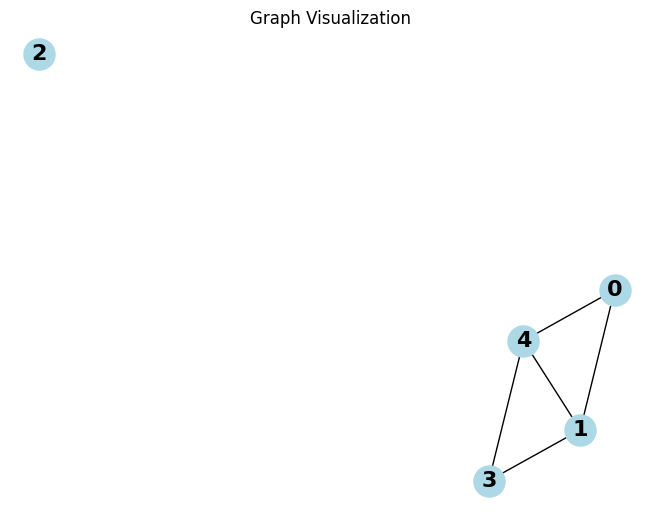


Graph without triangle:


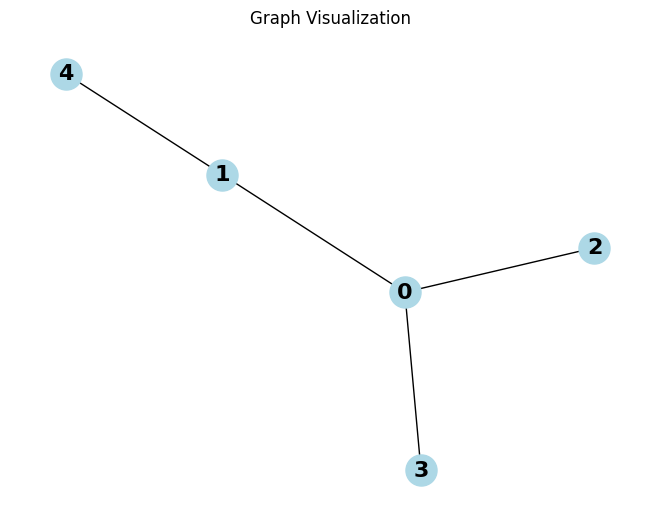


Verification:
Graphs with enforced triangle:
0

Graphs without triangle:
0


In [ ]:
from positional_encodings.torch_encodings import *
import numpy as np
import random
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pyvis.network import Network
from IPython.display import display, HTML

def has_triangle(matrix):
    n = matrix.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i,j]:  # if there's an edge between i and j
                for k in range(j+1, n):
                    if matrix[i,k] and matrix[j,k]:
                        return True
    return False

def generate_random_graphs(num_nodes, num_graphs=1, enforce_triangle=None):
    def generate_single_graph():
        # Initialize adjacency matrix
        adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

        if enforce_triangle is False:
            # Generate a triangle-free graph
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    # Check if adding this edge would create a triangle
                    can_add_edge = True
                    for k in range(num_nodes):
                        if k != i and k != j and adj_matrix[i, k] and adj_matrix[j, k]:
                            can_add_edge = False
                            break
                    if can_add_edge:
                        adj_matrix[i, j] = adj_matrix[j, i] = random.randint(0, 1)
        else:
            # Fill upper triangle (excluding diagonal) with random 0s and 1s
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    adj_matrix[i, j] = random.randint(0, 1)

            # Make the matrix symmetric
            adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

        # Handle triangle enforcement for True case
        if enforce_triangle is True and not has_triangle(adj_matrix):
            # Ensure at least one triangle
            while not has_triangle(adj_matrix):
                i, j, k = random.sample(range(num_nodes), 3)
                adj_matrix[i, j] = adj_matrix[j, i] = 1
                adj_matrix[i, k] = adj_matrix[k, i] = 1
                adj_matrix[j, k] = adj_matrix[k, j] = 1

        return adj_matrix

    # Generate the specified number of graphs
    graphs = [generate_single_graph() for _ in range(num_graphs)]

    return graphs

def show_graph_with_labels(adj_matrix, labels=None):
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)

    # If labels are not provided, use default integer labels
    if labels is None:
        labels = {i: str(i) for i in range(len(adj_matrix))}

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue',
            node_size=500, font_size=16, font_weight='bold')

    # Draw edge labels
    edge_labels = {(i, j): '' for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Graph Visualization")
    plt.axis('off')
    plt.show()


def show_interactive_graph_with_labels(adj_matrix, labels=None):
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)

    # If labels are not provided, use default integer labels
    if labels is None:
        labels = {i: str(i) for i in range(len(adj_matrix))}

    # Create a Pyvis network
    net = Network(notebook=True, directed=False, height="500px", width="100%", cdn_resources='remote')

    # Add nodes to the network
    for node in G.nodes():
        net.add_node(node, label=labels[node], title=f"Node: {labels[node]}\nConnections: {G.degree(node)}")

    # Add edges to the network
    for edge in G.edges():
        net.add_edge(edge[0], edge[1])

    # Set physics layout
    net.barnes_hut(gravity=-3000, central_gravity=0.3, spring_length=200, spring_strength=0.05, damping=0.09)

    # Generate and display the HTML
    html = net.generate_html()
    display(HTML(html))

# Example usage:
# show_interactive_graph_with_labels(adj_matrix, labels)

# Example usage:
num_nodes = 5
graphs_with_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=1, enforce_triangle=True)
graphs_without_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=1, enforce_triangle=False)
graphs_random = generate_random_graphs(num_nodes=num_nodes, num_graphs=1, enforce_triangle=None)

# Visualize the first graph from each category
print("Graph with enforced triangle:")
show_graph_with_labels(graphs_with_triangle[0])

print("\nGraph without triangle:")
show_graph_with_labels(graphs_without_triangle[0])

# Verification function
def verify_graphs(graphs, enforce_triangle):
    """
    Returns the number of errors found
    """
    results = []
    for graph in graphs:
        has_tri = has_triangle(graph)
        if enforce_triangle is False:
            results.append(has_tri)
        elif enforce_triangle is True:
            results.append(not has_tri)
        else:  # enforce_triangle is None
            results.append(True)  # Always true for random graphs
    return np.sum(np.array(results))

# Run verification
print("\nVerification:")
print("Graphs with enforced triangle:")
print(verify_graphs(graphs_with_triangle, True))
print("\nGraphs without triangle:")
print(verify_graphs(graphs_without_triangle, False))


In [ ]:
graphs_without_triangle

[array([[0, 1, 1, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])]

## Positional Encoding

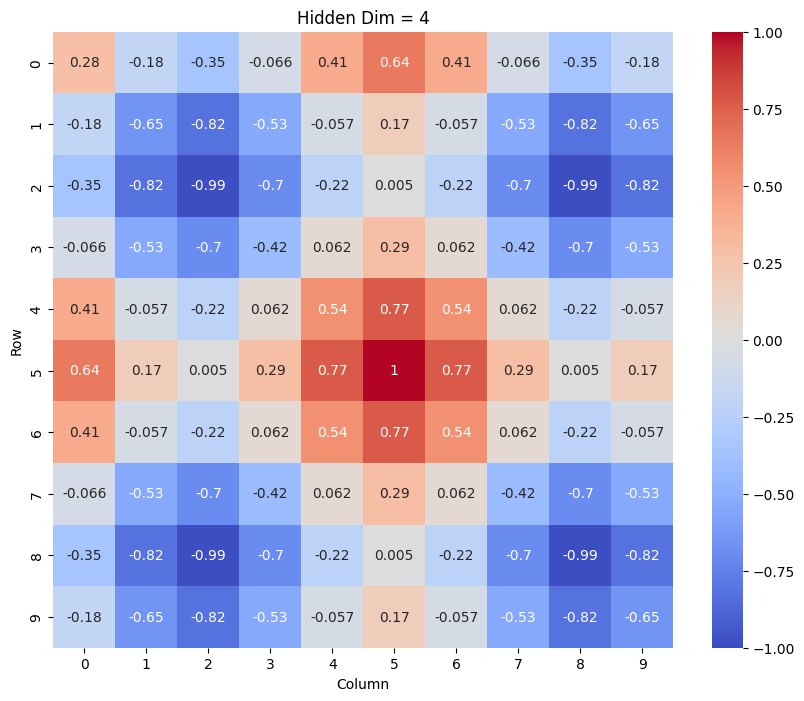

In [ ]:
hidden_dim = 4
n_nodes = 10
p_enc_2d = Summer(PositionalEncoding2D(hidden_dim))
todos = p_enc_2d(torch.zeros([1, n_nodes, n_nodes, hidden_dim]))
mitad  = p_enc_2d(torch.zeros([1, n_nodes, n_nodes, hidden_dim]))[:, n_nodes//2, n_nodes//2, :]

# Create example tensors
tensor1 = todos
tensor2 = mitad

# Reshape tensor1 to (1, 25, 5) for easier computation
tensor1_reshaped = tensor1.view(1, n_nodes**2, hidden_dim)

# Compute cosine similarity
cosine_sim = F.cosine_similarity(tensor1_reshaped, tensor2.unsqueeze(1), dim=2)

# Reshape the result to (5, 5) for heatmap
cosine_sim_reshaped = cosine_sim.view(n_nodes, n_nodes)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_reshaped.detach().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Hidden Dim = {hidden_dim}')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

## Vanilla Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphTransformerClassifier(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers):
        super(GraphTransformerClassifier, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        # 2D positional encoding
        self.pos_encoding = Summer(PositionalEncoding2D(hidden_dim))

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]
        #print(x.shape)
        #print(adj_matrix.shape)
        #print(adj_matrix.unsqueeze(-1).shape)

        # Add positional encoding
        x = self.pos_encoding(x)
        #print(x.shape)

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        for layer in self.layers:
            x = layer(x, attention_mask)
        #print(x.shape)

        # Global mean pooling
        graph_embedding = x.mean(dim=1)
        #print(graph_embedding.shape)


        # Binary classification
        output = self.classifier(graph_embedding)

        return output.squeeze()

class GraphTransformerLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(GraphTransformerLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Multi-head attention
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x, attention_mask):
        # x: node features [batch_size, max_nodes * max_nodes, hidden_dim]
        # attention_mask: [num_heads * batch_size, max_nodes * max_nodes, max_nodes * max_nodes]

        # Reshape for multi-head attention
        q = x.transpose(0, 1)
        k = x.transpose(0, 1)
        v = x.transpose(0, 1)

        # Compute attention scores
        attn_output, _ = self.attention(q, k, v, attn_mask=attention_mask)
        attn_output = attn_output.transpose(0, 1)

        # Residual connection and layer norm
        x = x + attn_output
        x = self.layer_norm1(x)

        # Feed-forward network
        ff_output = self.ffn(x)

        # Residual connection and layer norm
        x = x + ff_output
        x = self.layer_norm2(x)

        return x

# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.5099829435348511


## Dataset Generation

In [ ]:
def get_unique_adj_matrices(adj_matrices):
  all_graphs = [ tuple([tuple(r.tolist()) for r in g])  for g in adj_matrices]
  unique_graphs = set([ tuple([tuple(r.tolist()) for r in g]) for g in adj_matrices])
  unique_graphs_npy = [ np.array([list(r) for r in g])  for g in unique_graphs]
  return unique_graphs_npy

num_nodes = 8
max_nodes = num_nodes
dataset_size_target = 6000

graphs_with_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=True)
graphs_without_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=False)

adj_matrices = graphs_with_triangle + graphs_without_triangle

In [ ]:
def generate_dataset(dataset_size_target=6000, node_size_list=range(5, 11)):
  node_sizes = len(node_size_list)
  dataset_size_target // node_sizes
  node_size_target = dataset_size_target // node_sizes

  num_nodes = 4
  2**((num_nodes**2 - num_nodes)//2)

  adj_matrices = []
  labels = []
  sizes = dict()
  total_sizes = {"with": 0, "without": 0}
  for num_nodes in node_size_list:

    current_node_size_target = node_size_target

    if num_nodes <=5:
      max_existent_graphs = 2**((num_nodes**2 - num_nodes)//2)
      current_node_size_target = min(node_size_target, max_existent_graphs)
      node_size_target += node_size_target - current_node_size_target


    graphs_with_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=current_node_size_target//2, enforce_triangle=True)
    graphs_without_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=current_node_size_target//2, enforce_triangle=False)

    graphs_with_triangle_unique = get_unique_adj_matrices(graphs_with_triangle)
    graphs_without_triangle_unique = get_unique_adj_matrices(graphs_without_triangle)

    current_adj_matrices = graphs_with_triangle_unique + graphs_without_triangle_unique
    current_labels = [1 for _ in range(len(graphs_with_triangle_unique))] + [0 for _ in range(len(graphs_without_triangle_unique))]
    adj_matrices += current_adj_matrices
    labels += current_labels
    sizes[num_nodes] = {"with": len(graphs_with_triangle_unique), "without": len(graphs_without_triangle_unique)}
    total_sizes["with"] += len(graphs_with_triangle_unique)
    total_sizes["without"] += len(graphs_without_triangle_unique)

  dataset_size = len(adj_matrices)


  print("Dataset Size:", dataset_size)
  print("With Triangle Size:", total_sizes["with"])
  print("Without Triange Size:", total_sizes["without"])
  print("Totals for each node size:")
  print(sizes)
  ids = np.random.choice(range(dataset_size), size=dataset_size)
  adj_matrices, labels = zip(*random.sample(list(zip(adj_matrices, labels)), dataset_size))

  return adj_matrices, labels

In [ ]:
node_size_list=range(5, 11)
max_nodes = max(node_size_list)
dataset_size_target = 8000

adj_matrices, labels = generate_dataset(dataset_size_target, node_size_list)

# graphs_with_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=True)
# graphs_without_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=False)


# graphs_with_triangle_unique = get_unique_adj_matrices(graphs_with_triangle)
# graphs_without_triangle_unique = get_unique_adj_matrices(graphs_without_triangle)

# adj_matrices = graphs_with_triangle_unique + graphs_without_triangle_unique
# labels = [1 for _ in range(len(graphs_with_triangle_unique))] + [0 for _ in range(len(graphs_without_triangle_unique))]

# dataset_size = len(adj_matrices)

# print("Dataset Size:", dataset_size)
# print("With Triangle Size:", len(graphs_with_triangle_unique))
# print("Without Triange Size:", len(graphs_without_triangle_unique))

# ids = np.random.choice(range(dataset_size), size=dataset_size)
# adj_matrices, labels = zip(*random.sample(list(zip(adj_matrices, labels)), dataset_size))

# print(dataset_size)

class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

# adj_matrices: List of lists representing adjacency matrices
# labels: List of corresponding labels (0 or 1)

# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
hidden_dim = 32
num_heads = 8
num_layers = 1
lr = 1e-3
num_epochs = 8000

model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')


Dataset Size: 8579
With Triangle Size: 4442
Without Triange Size: 4137
Totals for each node size:
{5: {'with': 351, 'without': 245}, 6: {'with': 808, 'without': 658}, 7: {'with': 820, 'without': 785}, 8: {'with': 821, 'without': 810}, 9: {'with': 821, 'without': 818}, 10: {'with': 821, 'without': 821}}
Epoch 1/8000, Train Loss: 0.6894, Val Loss: 0.6871, Accuracy: 52.51%
Epoch 2/8000, Train Loss: 0.6847, Val Loss: 0.6837, Accuracy: 56.70%
Epoch 3/8000, Train Loss: 0.6803, Val Loss: 0.6793, Accuracy: 57.52%
Epoch 4/8000, Train Loss: 0.6748, Val Loss: 0.6738, Accuracy: 58.04%
Epoch 5/8000, Train Loss: 0.6677, Val Loss: 0.6675, Accuracy: 57.98%
Epoch 6/8000, Train Loss: 0.6596, Val Loss: 0.6601, Accuracy: 58.92%
Epoch 7/8000, Train Loss: 0.6510, Val Loss: 0.6527, Accuracy: 60.08%
Epoch 8/8000, Train Loss: 0.6433, Val Loss: 0.6459, Accuracy: 60.31%
Epoch 9/8000, Train Loss: 0.6356, Val Loss: 0.6400, Accuracy: 61.42%
Epoch 10/8000, Train Loss: 0.6295, Val Loss: 0.6342, Accuracy: 61.54%
Epoch

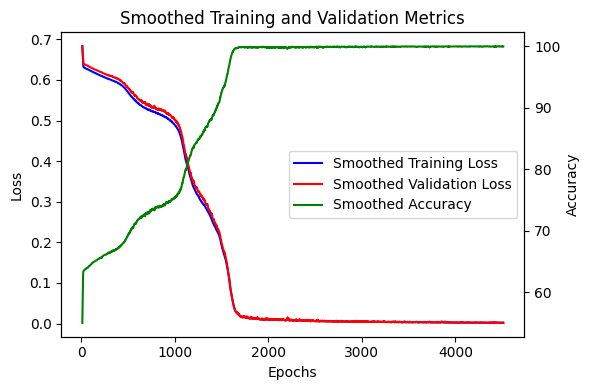

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Define the window size for the moving average
window_size = 10  # Adjust this value to control the amount of smoothing

# Apply smoothing to the data
smooth_train_losses = moving_average(train_losses, window_size)
smooth_val_losses = moving_average(val_losses, window_size)
smooth_accuracies = moving_average(accuracies, window_size)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot smoothed training and validation losses
epochs = range(window_size, len(train_losses) + 1)
ax1.plot(epochs, smooth_train_losses, 'b-', label='Smoothed Training Loss')
ax1.plot(epochs, smooth_val_losses, 'r-', label='Smoothed Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, smooth_accuracies, 'g-', label='Smoothed Accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Set title
plt.title('Smoothed Training and Validation Metrics')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Optionally, plot original data as faded lines for comparison
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.2)
ax1.plot(range(1, len(val_losses) + 1), val_losses, 'r-', alpha=0.2)
ax2.plot(range(1, len(accuracies) + 1), accuracies, 'g-', alpha=0.2)

plt.tight_layout()
plt.show()

## Detectar si los bordes pertenecen a un triángulo

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphTransformerTriangleEdgeDetector(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers):
        super(GraphTransformerTriangleEdgeDetector, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        # 2D positional encoding
        self.pos_encoding = Summer(PositionalEncoding2D(hidden_dim))

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Edge classifier
        self.edge_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        # Add positional encoding
        x = self.pos_encoding(x)

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        for layer in self.layers:
            x = layer(x, attention_mask)

        # Reshape back to [batch_size, max_nodes, max_nodes, hidden_dim]
        x = x.view(batch_size, self.max_nodes, self.max_nodes, self.hidden_dim)

        # Apply edge classifier
        edge_probs = self.edge_classifier(x).squeeze(-1)

        # Make the output symmetric and zero out the diagonal
        edge_probs = (edge_probs + edge_probs.transpose(1, 2)) / 2
        edge_probs = edge_probs * (1 - torch.eye(self.max_nodes, device=edge_probs.device))

        return edge_probs

# The GraphTransformerLayer remains the same as in the original code

# Example usage
max_nodes = 5
hidden_dim = 32  # Increased for better representation
num_heads = 4
num_layers = 3
model = GraphTransformerTriangleEdgeDetector(max_nodes, hidden_dim, num_heads, num_layers)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output = model(adj_matrix)
print(f"Output shape: {output.shape}")
print(f"Output probabilities:\n{output[0]}")

Output shape: torch.Size([1, 5, 5])
Output probabilities:
tensor([[0.0000, 0.4917, 0.4877, 0.5000, 0.4994],
        [0.4917, 0.0000, 0.4815, 0.4923, 0.4909],
        [0.4877, 0.4815, 0.0000, 0.4853, 0.4883],
        [0.5000, 0.4923, 0.4853, 0.0000, 0.4737],
        [0.4994, 0.4909, 0.4883, 0.4737, 0.0000]], grad_fn=<SelectBackward0>)


In [ ]:
import torch
import numpy as np
import hashlib

def generate_unique_random_graphs_with_triangles(num_nodes, edge_probability=0.3, num_graphs=1000, max_attempts=10000):
    """
    Generate unique random graphs with annotated triangle edges.

    Args:
    num_nodes (int): Number of nodes in each graph.
    edge_probability (float): Probability of an edge between any two nodes.
    num_graphs (int): Number of unique graphs to generate.
    max_attempts (int): Maximum number of attempts to generate unique graphs.

    Returns:
    tuple: (adj_matrices, edge_labels)
        adj_matrices: List of unique adjacency matrices (torch.Tensor)
        edge_labels: List of corresponding edge label matrices (torch.Tensor)
    """
    adj_matrices = []
    edge_labels = []
    graph_hashes = set()
    attempts = 0

    while len(adj_matrices) < num_graphs and attempts < max_attempts:
        # Generate random adjacency matrix
        adj_matrix = np.random.choice([0, 1], size=(num_nodes, num_nodes), p=[1-edge_probability, edge_probability])
        adj_matrix = np.triu(adj_matrix, 1)  # Upper triangular to avoid self-loops
        adj_matrix = adj_matrix + adj_matrix.T  # Make it symmetric

        # Generate a hash for this graph
        graph_hash = hashlib.md5(adj_matrix.tobytes()).hexdigest()

        # If this is a new, unique graph, process it
        if graph_hash not in graph_hashes:
            graph_hashes.add(graph_hash)

            # Find triangles
            triangle_edges = np.zeros((num_nodes, num_nodes))
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    if adj_matrix[i, j] == 1:
                        for k in range(j+1, num_nodes):
                            if adj_matrix[i, k] == 1 and adj_matrix[j, k] == 1:
                                triangle_edges[i, j] = triangle_edges[j, i] = 1
                                triangle_edges[i, k] = triangle_edges[k, i] = 1
                                triangle_edges[j, k] = triangle_edges[k, j] = 1

            adj_matrices.append(torch.tensor(adj_matrix, dtype=torch.float32))
            edge_labels.append(torch.tensor(triangle_edges, dtype=torch.float32))

        attempts += 1

    if len(adj_matrices) < num_graphs:
        print(f"Warning: Only generated {len(adj_matrices)} unique graphs out of {num_graphs} requested.")

    return adj_matrices, edge_labels

# Example usage:
num_nodes = 10
edge_probability = 0.3
num_graphs = 10000

adj_matrices, edge_labels = generate_unique_random_graphs_with_triangles(num_nodes, edge_probability, num_graphs)

print(f"Number of unique graphs generated: {len(adj_matrices)}")
print(f"Shape of each adjacency matrix: {adj_matrices[0].shape}")
print(f"Shape of each edge label matrix: {edge_labels[0].shape}")

# Example of one graph
print("\nExample Graph:")
print("Adjacency Matrix:")
print(adj_matrices[0])
print("\nEdge Labels (1 indicates edge is part of a triangle):")
print(edge_labels[0])

# Count triangles in the example graph
num_triangles = edge_labels[0].sum().item() // 3  # Divide by 3 as each triangle is counted 3 times
print(f"\nNumber of triangles in the example graph: {num_triangles}")

# Verify uniqueness
unique_hashes = set(hashlib.md5(adj.numpy().tobytes()).hexdigest() for adj in adj_matrices)
print(f"\nNumber of unique hashes: {len(unique_hashes)}")
print(f"All graphs are unique: {len(unique_hashes) == len(adj_matrices)}")

Number of unique graphs generated: 10000
Shape of each adjacency matrix: torch.Size([10, 10])
Shape of each edge label matrix: torch.Size([10, 10])

Example Graph:
Adjacency Matrix:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]])

Edge Labels (1 indicates edge is part of a triangle):
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0.,

In [ ]:
show_interactive_graph_with_labels(adj_matrices[0].numpy())

In [ ]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, adj_matrices, edge_labels):
        self.adj_matrices = adj_matrices
        self.edge_labels = edge_labels

    def __len__(self):
        return len(self.adj_matrices)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.edge_labels[idx]

def collate_fn(batch):
    adj_matrices, edge_labels = zip(*batch)
    adj_matrices = pad_sequence([adj.view(-1) for adj in adj_matrices], batch_first=True)
    edge_labels = pad_sequence([label.view(-1) for label in edge_labels], batch_first=True)
    max_nodes = int(adj_matrices.size(1)**0.5)
    return adj_matrices.view(-1, max_nodes, max_nodes), edge_labels.view(-1, max_nodes, max_nodes)

dataset = GraphDataset(adj_matrices, edge_labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
max_nodes = adj_matrices[0].shape[0]  # Assuming all matrices have the same size
hidden_dim = 32
num_heads = 8
num_layers = 1
lr = 1e-3
num_epochs = 8000

model = GraphTransformerTriangleEdgeDetector(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, edge_labels in train_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)

        optimizer.zero_grad()
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, edge_labels in test_loader:
            adj, edge_labels = adj.to(device), edge_labels.to(device)
            outputs = model(adj)

            # Apply mask to only consider existing edges
            mask = adj != 0
            loss = criterion(outputs[mask], edge_labels[mask])
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += mask.sum().item()
            correct += ((predicted == edge_labels) & mask).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, edge_labels in test_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += mask.sum().item()
        correct += ((predicted == edge_labels) & mask).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 1/8000, Train Loss: 0.6911, Val Loss: 0.6911, Accuracy: 52.78%
Epoch 2/8000, Train Loss: 0.6904, Val Loss: 0.6905, Accuracy: 52.78%
Epoch 3/8000, Train Loss: 0.6897, Val Loss: 0.6898, Accuracy: 52.78%
Epoch 4/8000, Train Loss: 0.6888, Val Loss: 0.6887, Accuracy: 52.79%
Epoch 5/8000, Train Loss: 0.6876, Val Loss: 0.6873, Accuracy: 53.28%
Epoch 6/8000, Train Loss: 0.6856, Val Loss: 0.6852, Accuracy: 53.74%
Epoch 7/8000, Train Loss: 0.6829, Val Loss: 0.6821, Accuracy: 56.61%
Epoch 8/8000, Train Loss: 0.6788, Val Loss: 0.6776, Accuracy: 56.30%
Epoch 9/8000, Train Loss: 0.6727, Val Loss: 0.6711, Accuracy: 58.87%
Epoch 10/8000, Train Loss: 0.6643, Val Loss: 0.6627, Accuracy: 60.53%
Epoch 11/8000, Train Loss: 0.6533, Val Loss: 0.6519, Accuracy: 63.06%
Epoch 12/8000, Train Loss: 0.6436, Val Loss: 0.6448, Accuracy: 63.35%
Epoch 13/8000, Train Loss: 0.6368, Val Loss: 0.6425, Accuracy: 63.26%
Epoch 14/8000, Train Loss: 0.6342, Val Loss: 0.6410, Accuracy: 63.40%
Epoch 15/8000, Train Loss: 0.

KeyboardInterrupt: 

In [ ]:
# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, edge_labels in test_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += mask.sum().item()
        correct += ((predicted == edge_labels) & mask).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Test Loss: 0.0004, Accuracy: 100.00%
